In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45043 instead
  warnings.warn(


In [92]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_10degdamping.nc", decode_times=False)

In [93]:
ctrl = xr.open_dataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_month.nc-09501231",
                         use_cftime=True)

In [94]:
dht = ctrl.dht[:,0]

In [95]:
lsm = xr.where(dht>0, 1, np.nan)

In [96]:
lsm = lsm.rename({"st_ocean":"DEPTH1_1", "yt_ocean":"GRID_Y_T", "xt_ocean":"GRID_X_T", "time": "TIME"})

In [97]:
lsm = lsm.assign_coords({"TIME": mask.TIME})

In [98]:
lsm = lsm.drop({"DEPTH1_1", "geolat_t", "geolon_t"})

In [99]:
mask["GRID_X_T"] = lsm["GRID_X_T"]
mask["GRID_Y_T"] = lsm["GRID_Y_T"]


In [100]:
basins = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc", decode_times = False)

In [101]:
basins = basins.BASIN_MASK

In [102]:
mask = mask.restore_mask

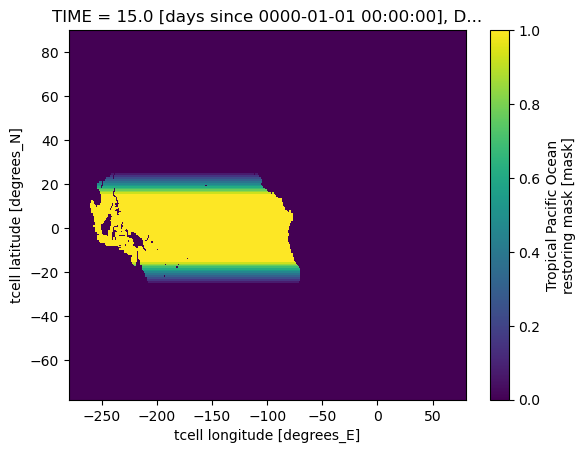

In [103]:
mask[0,0].plot()

In [104]:
PO = basins.where(basins == 3)

In [105]:
PO = xr.where(PO == 3, 1, 0)

In [106]:
PO = PO.rename({"ST_OCEAN1_1":"DEPTH1_1", "YT_OCEAN":"GRID_Y_T", "XT_OCEAN":"GRID_X_T"})

In [107]:
PO = PO.assign_coords({"DEPTH1_1":[0.0]})

In [108]:
PO2 = xr.concat([PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO], mask.TIME)

In [109]:
mask = mask.compute()

In [110]:
PO2 = PO2.compute()

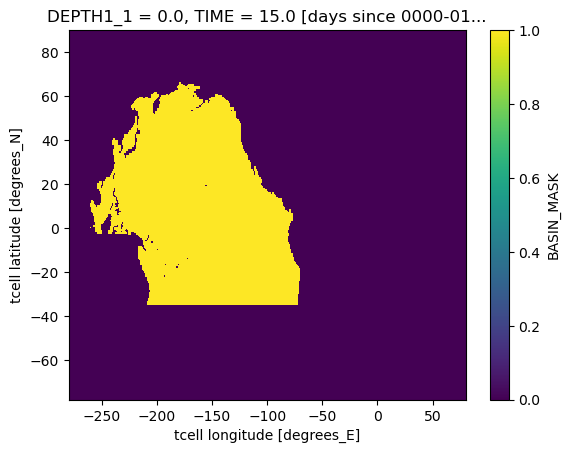

In [111]:
PO2[0,0].plot()

In [112]:
new = mask+PO2

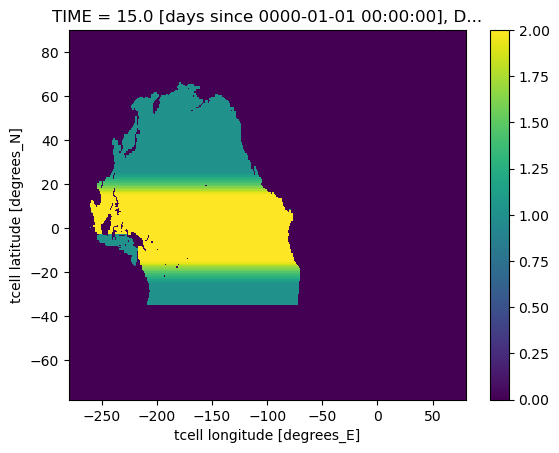

In [113]:
new[0,0].plot()

In [114]:
PO_30 = new.where(new.GRID_Y_T < 30, 0).where(new.GRID_Y_T > -30, 0)

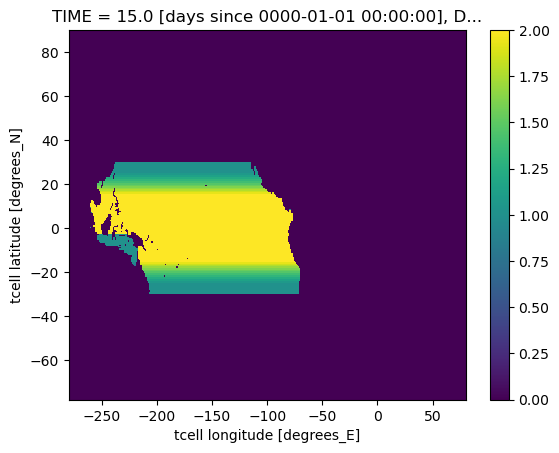

In [115]:
PO_30[0,0].plot()

In [116]:
PO_30_1 = xr.where(PO_30 >0, 1, 0)

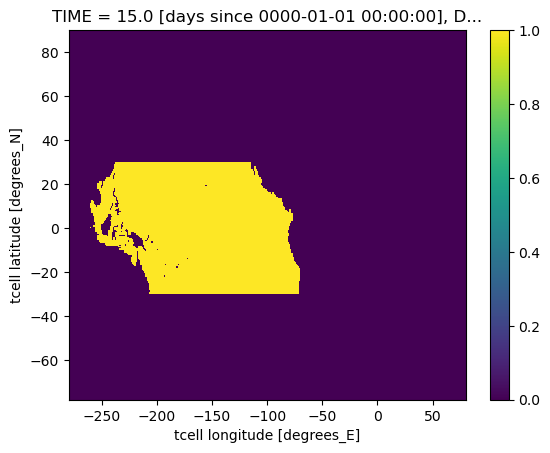

In [117]:
PO_30_1[0,0].plot()

In [118]:
PO_30_1.sel(GRID_Y_T=0, GRID_X_T=-261, method = "nearest")

<xarray.DataArray (TIME: 12, DEPTH1_1: 1)>
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
    GRID_Y_T  float64 0.1662
    GRID_X_T  float64 -260.5

In [120]:
latitude_values = PO_30_1.coords['GRID_Y_T']

# Create an array the same size as lat x lon with latitude values
# Repeat latitude values across lon dimension
latitude_array = xr.DataArray(latitude_values.data[:, None] * xr.ones_like(PO_30_1[0,0], dtype=bool),
                              dims=['GRID_Y_T', 'GRID_X_T'])

In [121]:
lower_limit = 25
upper_limit = 30

# Apply linear transformation to values between 25 and 30
masked_array = np.where(
    (latitude_array >= lower_limit) & (latitude_array <= upper_limit),
    1 - (latitude_array - lower_limit) / (upper_limit - lower_limit),
    latitude_array
)

# Create an xarray DataArray with the transformed values
transformed_latitude_array = xr.DataArray(masked_array, dims=['lat', 'lon'])


In [122]:
lower_limit = -30
upper_limit = -25
lowers = ((latitude_array - lower_limit) / (upper_limit - lower_limit))

lower_limit = 25
upper_limit = 30
uppers = (1-(latitude_array - lower_limit) / (upper_limit - lower_limit))

In [123]:
uppers = (uppers.where(uppers>0, 0).where(uppers<1,1)).where(lowers.GRID_Y_T>-25,0)

In [124]:
lowers = (lowers.where(lowers>0, 0).where(lowers<1,1)).where(lowers.GRID_Y_T<25,0)

In [125]:
latitude_mask = (lowers+uppers).where((lowers+uppers)<2, 1)

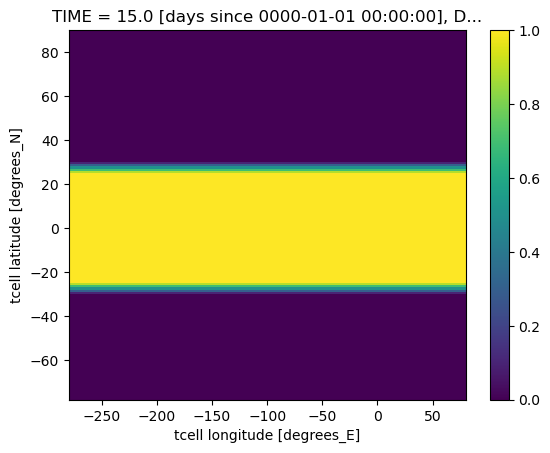

In [126]:
latitude_mask.plot()

In [127]:
#add the time and depth dimesnion to latidue mask

In [128]:
latitude_mask = latitude_mask.expand_dims(dim = {"TIME":mask.TIME}, axis = 0).expand_dims(dim = {"DEPTH1_1":[0.0]}, axis = 1)

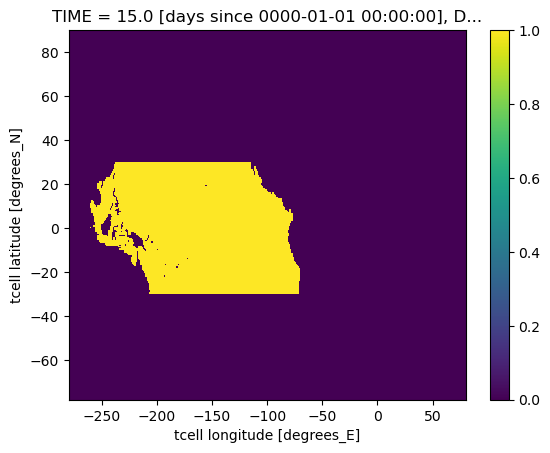

In [129]:
PO_30_1[0,0].plot()

In [130]:
new_mask = latitude_mask.where(PO_30_1>0, 0)

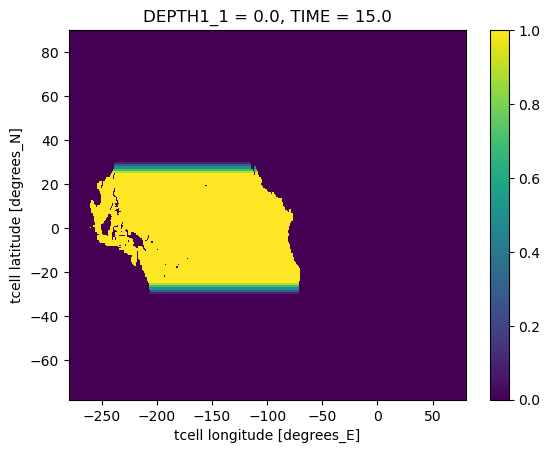

In [131]:
new_mask[0,0].plot()

In [168]:
#correctly mask land sea points

In [169]:
new_mask2 = new_mask.where(lsm >0)

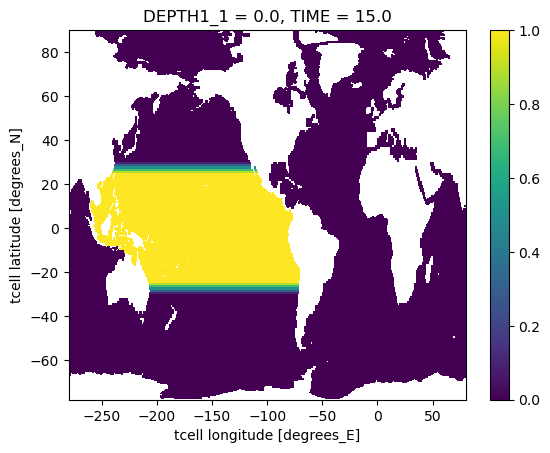

In [170]:
new_mask2[0,0].plot()

In [171]:
new_mask3 = new_mask2.fillna(0)

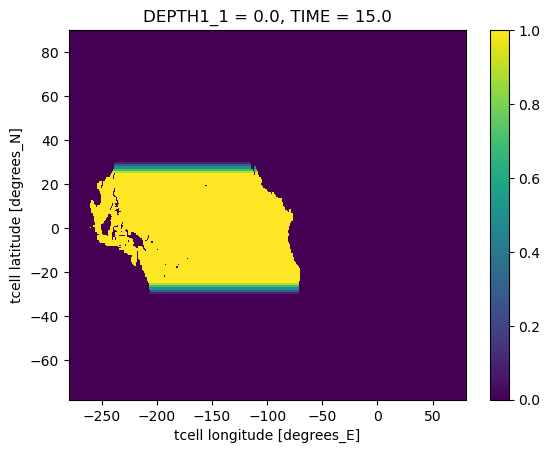

In [172]:
new_mask3[0,0].plot()

In [173]:
#mask point at 0,-261 that is in the indian ocean

In [174]:
nearest_point = new_mask3.sel(GRID_Y_T=0, GRID_X_T=-261, method = "nearest")

In [175]:
new_mask3.loc[dict(GRID_Y_T=nearest_point.GRID_Y_T, GRID_X_T=nearest_point.GRID_X_T)] = 0

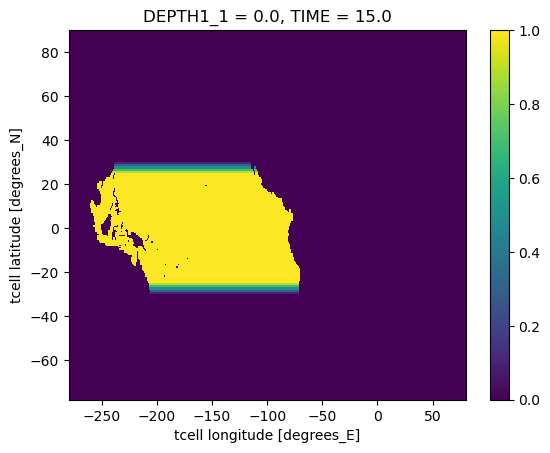

In [176]:
new_mask3[0,0].plot()

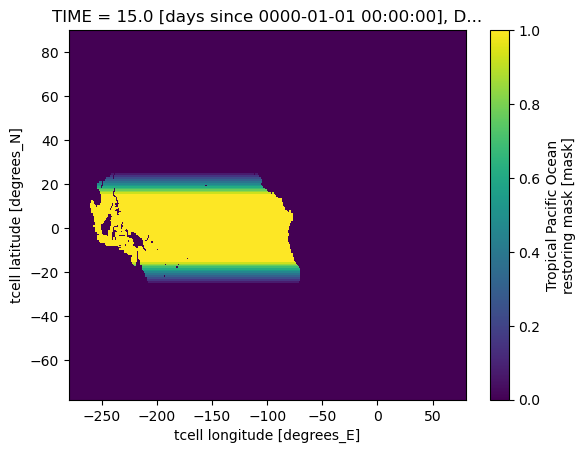

In [177]:
mask[0,0].plot()

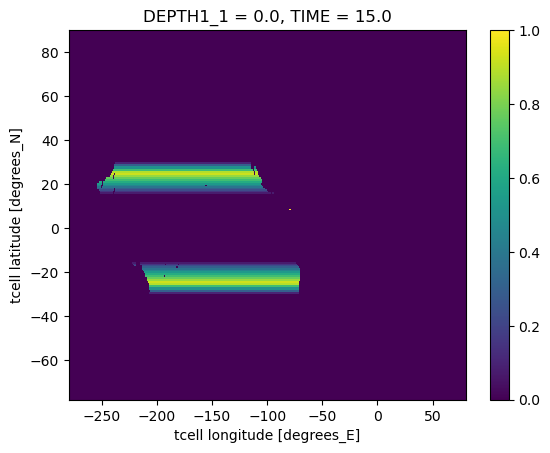

In [178]:
(new_mask3-mask)[0,0].plot()

In [179]:
new_mask3 = new_mask3.assign_coords({"TIME":mask.TIME, "DEPTH1_1":mask.DEPTH1_1, "GRID_X_T":mask.GRID_X_T, "GRID_Y_T":mask.GRID_Y_T})

In [180]:
new_mask3 = new_mask3.assign_attrs({"long_name": "Tropical Pacific Ocean restoring mask", "units": "mask"})
new_mask3 = new_mask3.astype("float32")
new_mask3 = new_mask3.to_dataset(name = 'restore_mask')
new_mask3 = new_mask3.assign_attrs({"description": "Tropical Pacific Ocean restore mask 25S-25N plus 5deg damping to 30S-30N (1=restore, 0=no restore) for ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 5/03/24"})

In [181]:
new_mask3.to_netcdf("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_25N_25S_5deg_damping_trop_pacific.nc", mode='w', format='NETCDF4' 
                    , encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "restore_mask": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [182]:
test = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_10degdamping.nc", decode_times=False)

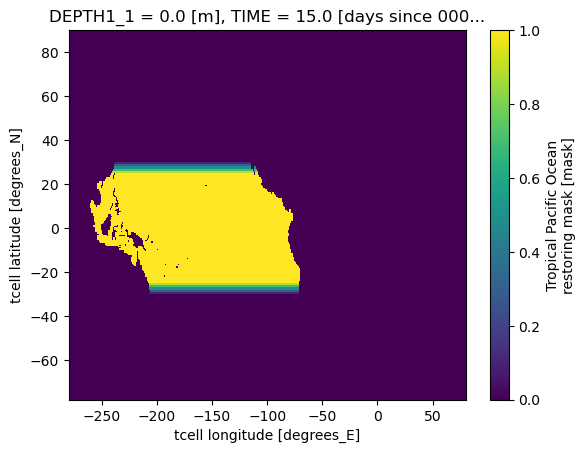

In [184]:
new_mask3.restore_mask[0,0].plot()

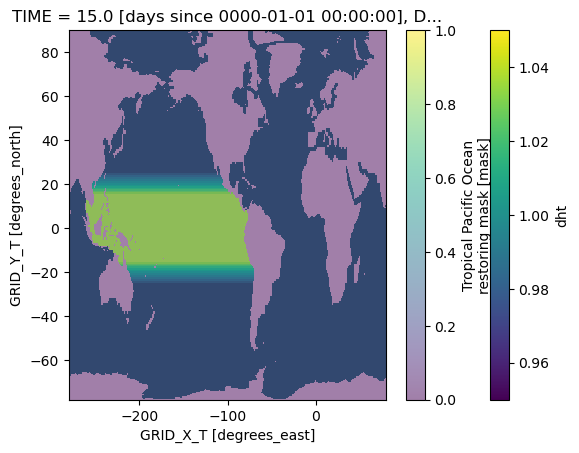

In [185]:
lsm[0].plot()
test.restore_mask[0,0].plot(alpha = 0.5)

In [178]:
test.close()

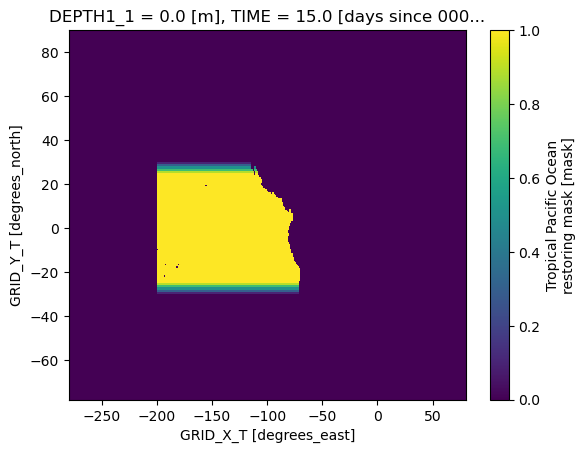

In [171]:
new_mask3.restore_mask[0,0].plot()

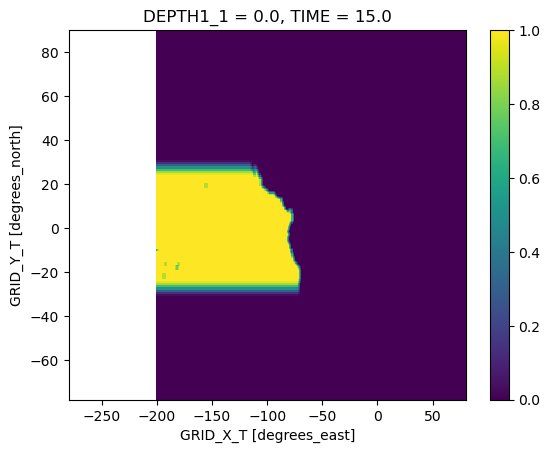

In [185]:
new_mask2[0,0].rolling(GRID_X_T=3, GRID_Y_T=3, center=True, min_periods=1).mean().plot()